In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Load Dataset

In [110]:
df_airbnb = pd.read_csv('./airbnb.csv')
df_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Check Data Info

In [111]:
df_airbnb.shape

(48895, 16)

---

In [112]:
df_airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [113]:
df_airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [114]:
# Membersihkan data dengan menghapus baris yang memiliki nilai kosong di name dan host_name
df_airbnb_clean = df_airbnb.dropna(subset=['name', 'host_name'])

# Mengecek kembali data yang kosong
print(df_airbnb_clean.isnull().sum())

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10037
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
dtype: int64


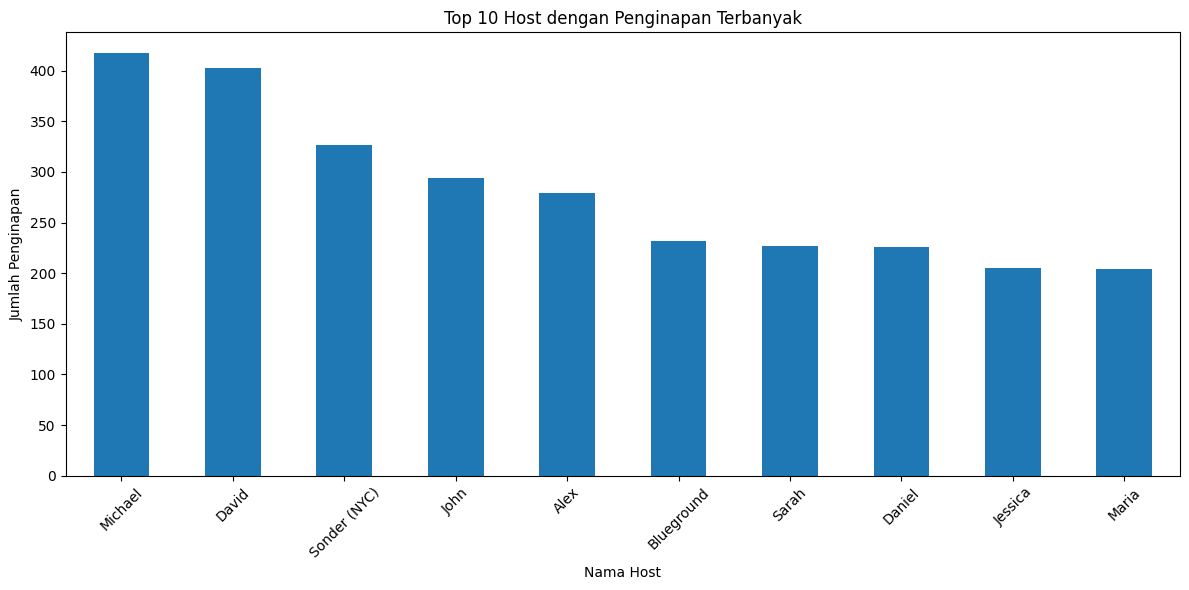

Host dengan penginapan terbanyak:
host_name
Michael         417
David           403
Sonder (NYC)    327
John            294
Alex            279
Blueground      232
Sarah           227
Daniel          226
Jessica         205
Maria           204
Name: count, dtype: int64


In [115]:
# Host dengan penginapan terbanyak
top_hosts = df_airbnb_clean['host_name'].value_counts().head(10)

# Visualisasi diagram batang
plt.figure(figsize=(12, 6))
top_hosts.plot(kind='bar')
plt.title('Top 10 Host dengan Penginapan Terbanyak')
plt.xlabel('Nama Host')
plt.ylabel('Jumlah Penginapan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menampilkan data
print("Host dengan penginapan terbanyak:")
print(top_hosts)

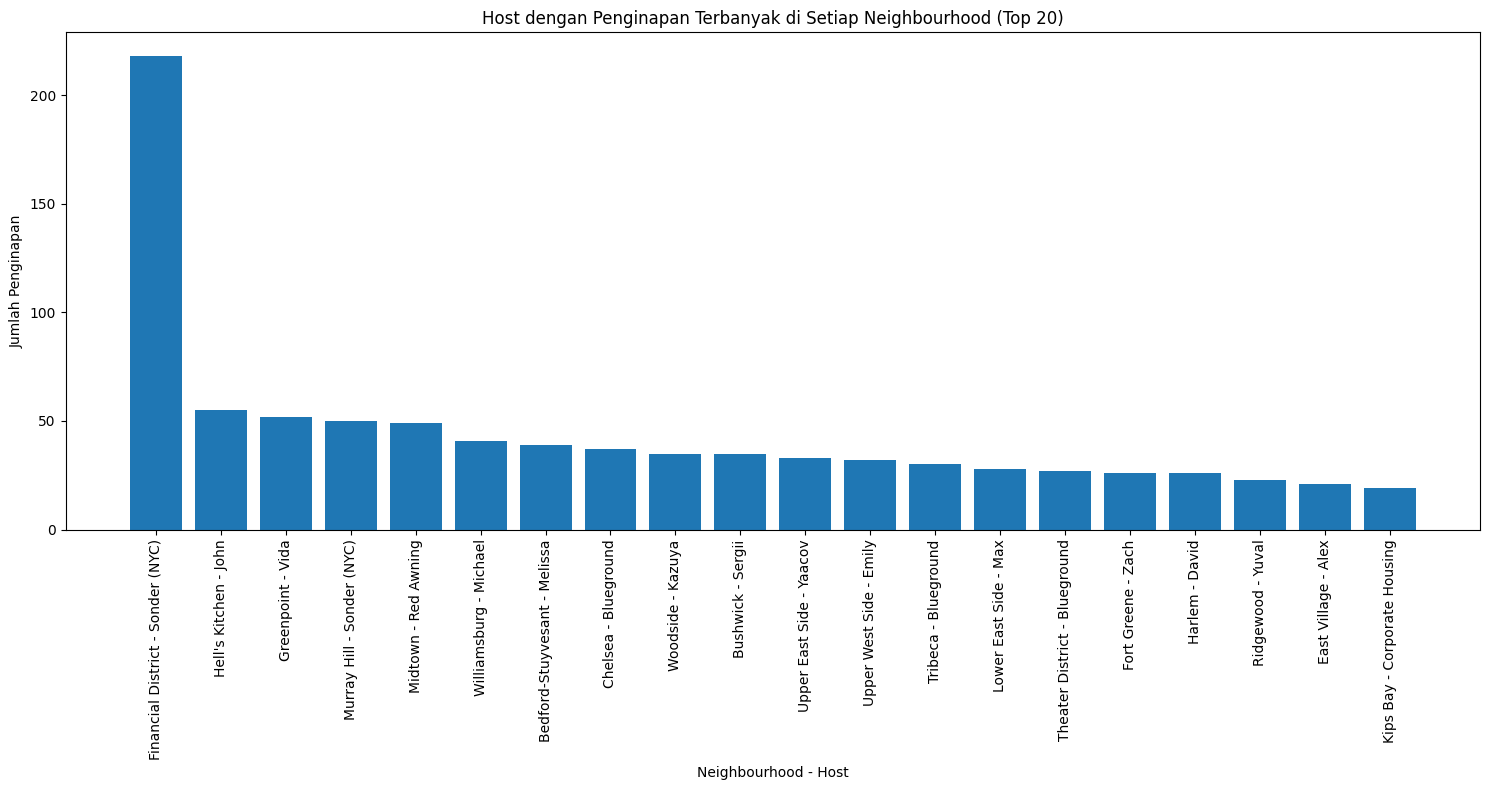

Host dengan penginapan terbanyak di setiap neighbourhood (diurutkan dari yang terbanyak):
            neighbourhood          host_name  count
10615  Financial District       Sonder (NYC)    218
15267      Hell's Kitchen               John     55
13101          Greenpoint               Vida     52
19522         Murray Hill       Sonder (NYC)     50
18651             Midtown         Red Awning     49
27954        Williamsburg            Michael     41
2090   Bedford-Stuyvesant            Melissa     39
4927              Chelsea         Blueground     37
28785            Woodside             Kazuya     35
4351             Bushwick             Sergii     35
24443     Upper East Side             Yaacov     33
24771     Upper West Side              Emily     32
23323             Tribeca         Blueground     30
17759     Lower East Side                Max     28
23139    Theater District         Blueground     27
11899         Fort Greene               Zach     26
13723              Harlem 

In [116]:
# Host dengan penginapan terbanyak di setiap neighbourhood
top_hosts_by_neighbourhood = df_airbnb_clean.groupby(['neighbourhood', 'host_name']).size().reset_index(name='count')

# Mengurutkan berdasarkan jumlah penginapan (dari terbesar ke terkecil)
top_hosts_sorted = top_hosts_by_neighbourhood.sort_values('count', ascending=False).drop_duplicates('neighbourhood')

# Membuat label gabungan untuk visualisasi
top_hosts_sorted['neighbourhood_host'] = top_hosts_sorted['neighbourhood'] + ' - ' + top_hosts_sorted['host_name']

# Visualisasi diagram batang untuk top 20
plt.figure(figsize=(15, 8))
plt.bar(top_hosts_sorted.head(20)['neighbourhood_host'], top_hosts_sorted.head(20)['count'])
plt.title('Host dengan Penginapan Terbanyak di Setiap Neighbourhood (Top 20)')
plt.xlabel('Neighbourhood - Host')
plt.ylabel('Jumlah Penginapan')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Menampilkan data
print("Host dengan penginapan terbanyak di setiap neighbourhood (diurutkan dari yang terbanyak):")
print(top_hosts_sorted[['neighbourhood', 'host_name', 'count']].head(20))

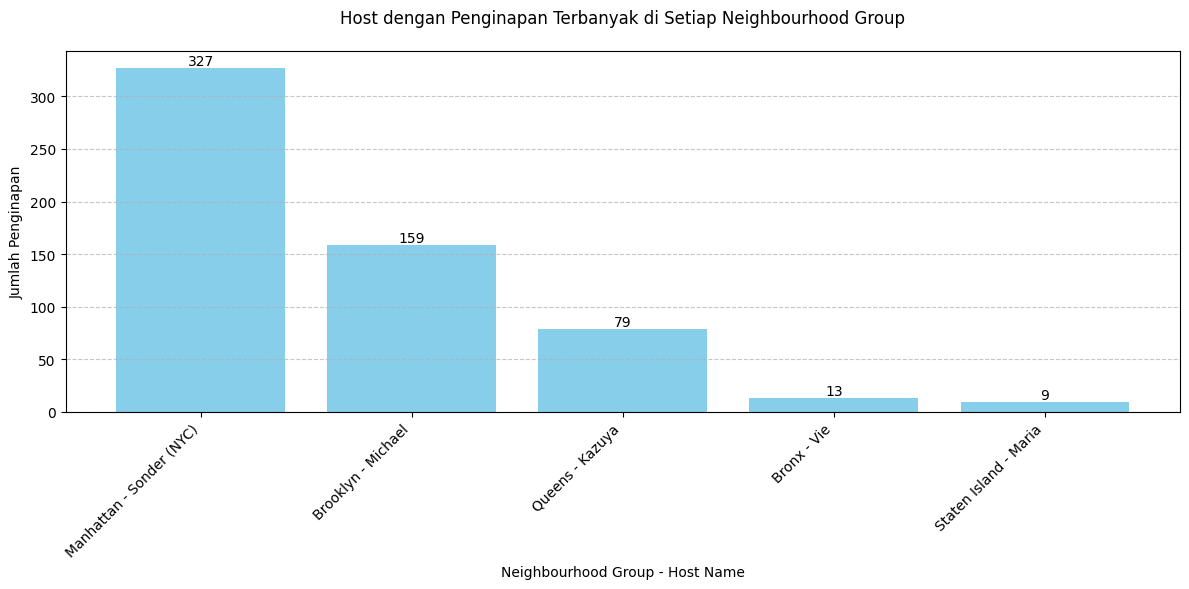

Host dengan penginapan terbanyak di setiap neighbourhood group:


,neighbourhood_group,host_name,count
0,Manhattan,Sonder (NYC),327
1,Brooklyn,Michael,159
2,Queens,Kazuya,79
3,Bronx,Vie,13
4,Staten Island,Maria,9


In [117]:
# 1. Hitung jumlah penginapan per host di setiap neighbourhood group
hosts_by_group = df_airbnb_clean.groupby(['neighbourhood_group', 'host_name']).size().reset_index(name='count')

# 2. Ambil host dengan jumlah penginapan terbanyak di setiap neighbourhood group
top_hosts_by_group = hosts_by_group.loc[hosts_by_group.groupby('neighbourhood_group')['count'].idxmax()]

# 3. Urutkan dari yang memiliki penginapan terbanyak
top_hosts_by_group_sorted = top_hosts_by_group.sort_values('count', ascending=False)

# 4. Visualisasi diagram batang
plt.figure(figsize=(12, 6))
bars = plt.bar(
    top_hosts_by_group_sorted['neighbourhood_group'] + ' - ' + top_hosts_by_group_sorted['host_name'],
    top_hosts_by_group_sorted['count'],
    color='skyblue'
)

# Tambahkan label nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Host dengan Penginapan Terbanyak di Setiap Neighbourhood Group', pad=20)
plt.xlabel('Neighbourhood Group - Host Name')
plt.ylabel('Jumlah Penginapan')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Tampilkan data dalam tabel
print("Host dengan penginapan terbanyak di setiap neighbourhood group:")
display(top_hosts_by_group_sorted[['neighbourhood_group', 'host_name', 'count']].reset_index(drop=True))

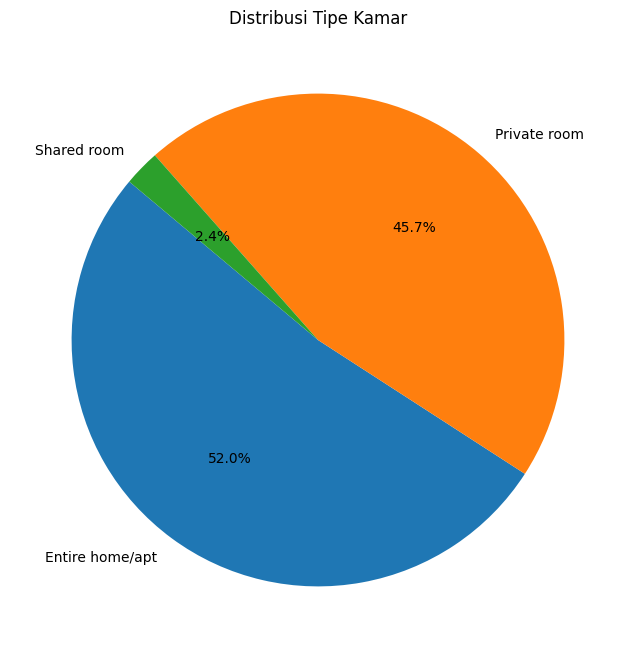

Jumlah penginapan berdasarkan tipe kamar:
room_type
Entire home/apt    25393
Private room       22306
Shared room         1159
Name: count, dtype: int64


In [118]:
# Jumlah untuk semua tipe di room_type
room_type_counts = df_airbnb_clean['room_type'].value_counts()

# Visualisasi pie chart
plt.figure(figsize=(8, 8))
plt.pie(room_type_counts, labels=room_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Tipe Kamar')
plt.show()

# Menampilkan data
print("Jumlah penginapan berdasarkan tipe kamar:")
print(room_type_counts)

In [119]:
# Style tabel dengan pandas
top_10_expensive = df_airbnb_clean.nlargest(10, 'price')[['name', 'price', 'neighbourhood', 'room_type']]

# Rename kolom untuk tampilan lebih baik
top_10_expensive.columns = ['Nama Penginapan', 'Harga ($)', 'Neighbourhood', 'Tipe Kamar']

# Tampilkan dengan styling
display(
    top_10_expensive.style
    .set_caption('10 Penginapan dengan Harga Tertinggi')
    .format({'Harga ($)': '${:,.0f}'})  # Format harga sebagai mata uang
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f8f8f8'), 
                                    ('font-weight', 'bold'),
                                    ('text-align', 'center')]}
    ])
    .background_gradient(cmap='Reds', subset=['Harga ($)'])  # Warna gradient untuk kolom harga
)

,Nama Penginapan,Harga ($),Neighbourhood,Tipe Kamar
9151,Furnished room in Astoria apartment,"$10,000",Astoria,Private room
17692,Luxury 1 bedroom apt. -stunning Manhattan views,"$10,000",Greenpoint,Entire home/apt
29238,1-BR Lincoln Center,"$10,000",Upper West Side,Entire home/apt
6530,Spanish Harlem Apt,"$9,999",East Harlem,Entire home/apt
12342,"Quiet, Clean, Lit @ LES & Chinatown","$9,999",Lower East Side,Private room
40433,2br - The Heart of NYC: Manhattans Lower East Side,"$9,999",Lower East Side,Entire home/apt
30268,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,"$8,500",Tribeca,Entire home/apt
4377,Film Location,"$8,000",Clinton Hill,Entire home/apt
29662,East 72nd Townhouse by (Hidden by Airbnb),"$7,703",Upper East Side,Entire home/apt
42523,70' Luxury MotorYacht on the Hudson,"$7,500",Battery Park City,Entire home/apt


In [120]:
# Prepare data
top_cheapest = (
    df_airbnb_clean[df_airbnb_clean['price'] > 0]
    .nsmallest(12, 'price')
    [['name', 'price', 'neighbourhood', 'room_type', 'minimum_nights']]
    .rename(columns={
        'name': 'Nama Penginapan',
        'price': 'Harga ($)',
        'neighbourhood': 'Lokasi',
        'room_type': 'Tipe Kamar',
        'minimum_nights': 'Min. Menginap'
    })
)

# Style the table
(top_cheapest.style
    .set_caption('<h3 style="text-align:center; font-size:16px; color:#E67E22">5 Penginapan dengan Harga Terendah</h3>')
    .format({
        'Harga ($)': '${:,.0f}',
        'Min. Menginap': '{:.0f} malam'
    })
    .set_properties(**{
        'text-align': 'left',
        'padding': '6px',
        'border': '1px solid #ddd'
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#E67E22'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px'),
            ('border', '1px solid #D35400')
        ]
    }])
    .bar(subset=['Harga ($)'], color='#F5B041', vmin=0)
    .hide(axis='index')
)

Nama Penginapan,Harga ($),Lokasi,Tipe Kamar,Min. Menginap
Large furnished 2 bedrooms- - 30 days Minimum,$10,East Village,Entire home/apt,30 malam
Couch in Harlem Harvey Refugees only,$10,Harlem,Shared room,1 malam
"Newly renovated, fully furnished room in Brooklyn",$10,Bushwick,Private room,5 malam
Jen Apt,$10,SoHo,Private room,5 malam
IT'S SIMPLY CONVENIENT!,$10,Jamaica,Entire home/apt,1 malam
"Quiet, Cozy UES Studio Near the Subway",$10,Upper East Side,Entire home/apt,3 malam
"Girls only, cozy room one block from Times Square",$10,Hell's Kitchen,Shared room,1 malam
Spacious 2-bedroom Apt in Heart of Greenpoint,$10,Greenpoint,Entire home/apt,1 malam
"Very Spacious bedroom, steps from CENTRAL PARK.",$10,Upper West Side,Private room,1 malam
Cozy feel at home studio,$10,Kips Bay,Private room,5 malam


In [121]:
# Prepare data (tanpa reviews_per_month)
top_reviews = (
    df_airbnb_clean.nlargest(10, 'number_of_reviews')
    [['name', 'number_of_reviews', 'neighbourhood', 'room_type']]  # Hanya kolom yang diperlukan
    .rename(columns={
        'name': 'Nama Penginapan',
        'number_of_reviews': 'Total Review', 
        'neighbourhood': 'Lokasi',
        'room_type': 'Tipe Kamar'
    })
)

# Style the table
(top_reviews.style
    .set_caption('<h3 style="text-align:center; font-size:16px; color:#9B59B6">5 Penginapan dengan Review Terbanyak</h3>')
    .format({
        'Total Review': '{:,}'  # Format angka dengan separator ribuan
    })
    .set_properties(**{
        'text-align': 'left',
        'padding': '6px',
        'border': '1px solid #ddd',
        'max-width': '400px'  # Lebar lebih besar untuk nama penginapan
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#9B59B6'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px'),
            ('border', '1px solid #8E44AD'),
            ('position', 'sticky'),
            ('top', '0')
        ]
    },
    {
        'selector': 'tr:hover',
        'props': [('background-color', '#F5EEF8')]  # Efek hover ungu muda
    }])
    .bar(subset=['Total Review'], color='#BB8FCE', vmin=0)  # Bar chart hanya untuk total review
    .hide(axis='index')  # Sembunyikan index
)

Nama Penginapan,Total Review,Lokasi,Tipe Kamar
Room near JFK Queen Bed,629,Jamaica,Private room
Great Bedroom in Manhattan,607,Harlem,Private room
Beautiful Bedroom in Manhattan,597,Harlem,Private room
Private Bedroom in Manhattan,594,Harlem,Private room
Room Near JFK Twin Beds,576,Jamaica,Private room
Steps away from Laguardia airport,543,East Elmhurst,Private room
Manhattan Lux Loft.Like.Love.Lots.Look !,540,Lower East Side,Private room
Cozy Room Family Home LGA Airport NO CLEANING FEE,510,East Elmhurst,Private room
Private brownstone studio Brooklyn,488,Park Slope,Entire home/apt
LG Private Room/Family Friendly,480,Bushwick,Private room


In [122]:
# Prepare data
top_reviews = (
    df_airbnb_clean.nlargest(5, 'reviews_per_month')
    [['name', 'reviews_per_month', 'neighbourhood', 'room_type', 'number_of_reviews']]
    .rename(columns={
        'name': 'Nama Penginapan',
        'reviews_per_month': 'Review/Bulan',
        'neighbourhood': 'Lokasi',
        'room_type': 'Tipe Kamar',
        'number_of_reviews': 'Total Review'
    })
)

# Style the table
(top_reviews.style
    .set_caption('<h3 style="text-align:center; font-size:16px; color:#2E86C1">5 Penginapan dengan Review per Month Terbanyak</h3>')
    .format({
        'Review/Bulan': '{:.2f}',
        'Total Review': '{:,}'
    })
    .set_properties(**{
        'text-align': 'left',
        'padding': '6px',
        'border': '1px solid #ddd'
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#3498DB'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px'),
            ('border', '1px solid #2980B9')
        ]
    }])
    .bar(subset=['Review/Bulan'], color='#5DADE2', vmin=0)
    .hide(axis='index')
)

Nama Penginapan,Review/Bulan,Lokasi,Tipe Kamar,Total Review
Enjoy great views of the City in our Deluxe Room!,58.50,Theater District,Private room,156
Great Room in the heart of Times Square!,27.95,Theater District,Private room,82
Lou's Palace-So much for so little,20.94,Rosedale,Private room,37
JFK Comfort.5 Mins from JFK Private Bedroom & Bath,19.75,Springfield Gardens,Private room,403
JFK 2 Comfort 5 Mins from JFK Private Bedroom,17.82,Springfield Gardens,Private room,341


In [123]:
# Prepare data
top_available = (
    df_airbnb_clean.nlargest(5, 'availability_365')
    [['name', 'availability_365', 'neighbourhood', 'room_type', 'price']]
    .rename(columns={
        'name': 'Nama Penginapan',
        'availability_365': 'Hari Tersedia',
        'neighbourhood': 'Lokasi',
        'room_type': 'Tipe Kamar',
        'price': 'Harga ($)'
    })
)

# Style the table
(top_available.style
    .set_caption('<h3 style="text-align:center; font-size:16px; color:#27AE60">5 Penginapan dengan Ketersediaan Terbanyak</h3>')
    .format({
        'Hari Tersedia': '{:.0f} hari',
        'Harga ($)': '${:,.0f}'
    })
    .set_properties(**{
        'text-align': 'left',
        'padding': '6px',
        'border': '1px solid #ddd'
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#2ECC71'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px'),
            ('border', '1px solid #27AE60')
        ]
    }])
    .bar(subset=['Hari Tersedia'], color='#58D68D', vmin=0)
    .hide(axis='index')
)

Nama Penginapan,Hari Tersedia,Lokasi,Tipe Kamar,Harga ($)
Clean & quiet apt home by the park,365 hari,Kensington,Private room,$149
THE VILLAGE OF HARLEM....NEW YORK !,365 hari,Harlem,Private room,$150
Clean and Quiet in Brooklyn,365 hari,Bedford-Stuyvesant,Private room,$35
Country space in the city,365 hari,Flatbush,Private room,$150
"Upper Manhattan, New York",365 hari,Harlem,Private room,$89


In [124]:
# Prepare data (tanpa price dan availability_365)
top_min_nights = (
    df_airbnb_clean.nlargest(5, 'minimum_nights')
    [['name', 'minimum_nights', 'neighbourhood', 'room_type']]  # Hanya kolom yang diperlukan
    .rename(columns={
        'name': 'Nama Penginapan',
        'minimum_nights': 'Minimum Stay',
        'neighbourhood': 'Lokasi',
        'room_type': 'Tipe Kamar'
    })
)

# Style the table
(top_min_nights.style
    .set_caption('<h3 style="text-align:center; font-size:16px; color:#16A085">5 Penginapan dengan Minimum Stay Terpanjang</h3>')
    .format({
        'Minimum Stay': '{:.0f} malam'  # Format untuk minimum stay
    })
    .set_properties(**{
        'text-align': 'left',
        'padding': '6px',
        'border': '1px solid #ddd',
        'max-width': '400px'  # Lebar lebih besar untuk nama penginapan
    })
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', '#1ABC9C'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px'),
            ('border', '1px solid #16A085'),
            ('position', 'sticky'),
            ('top', '0')
        ]
    },
    {
        'selector': 'tr:hover',
        'props': [('background-color', '#E8F8F5')]  # Efek hover
    }])
    .bar(subset=['Minimum Stay'], color='#76D7C4', vmin=0)  # Bar chart hanya untuk minimum stay
    .hide(axis='index')  # Sembunyikan index
)

Nama Penginapan,Minimum Stay,Lokasi,Tipe Kamar
Prime W. Village location 1 bdrm,1250 malam,Greenwich Village,Entire home/apt
Historic Designer 2 Bed. Apartment,999 malam,Harlem,Entire home/apt
Beautiful place in Brooklyn! #2,999 malam,Williamsburg,Private room
Shared Studio (females only),999 malam,Greenwich Village,Shared room
Beautiful Fully Furnished 1 bed/bth,500 malam,Long Island City,Entire home/apt


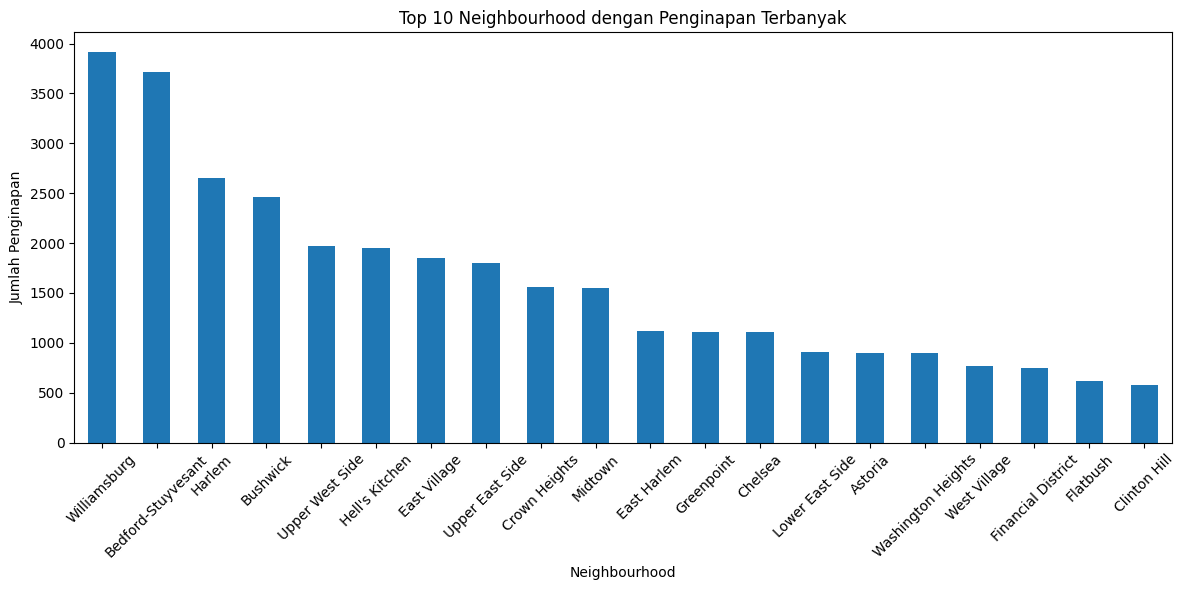

Neighbourhood dengan penginapan terbanyak:
neighbourhood
Williamsburg          3917
Bedford-Stuyvesant    3713
Harlem                2655
Bushwick              2462
Upper West Side       1969
Hell's Kitchen        1954
East Village          1852
Upper East Side       1797
Crown Heights         1563
Midtown               1545
East Harlem           1116
Greenpoint            1113
Chelsea               1112
Lower East Side        911
Astoria                900
Washington Heights     898
West Village           768
Financial District     744
Flatbush               619
Clinton Hill           572
Name: count, dtype: int64


In [125]:
# Neighbourhood dengan jumlah penginapan terbanyak
top_neighbourhoods = df_airbnb_clean['neighbourhood'].value_counts().head(20)

# Visualisasi diagram batang
plt.figure(figsize=(12, 6))
top_neighbourhoods.plot(kind='bar')
plt.title('Top 10 Neighbourhood dengan Penginapan Terbanyak')
plt.xlabel('Neighbourhood')
plt.ylabel('Jumlah Penginapan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menampilkan data
print("Neighbourhood dengan penginapan terbanyak:")
print(top_neighbourhoods)

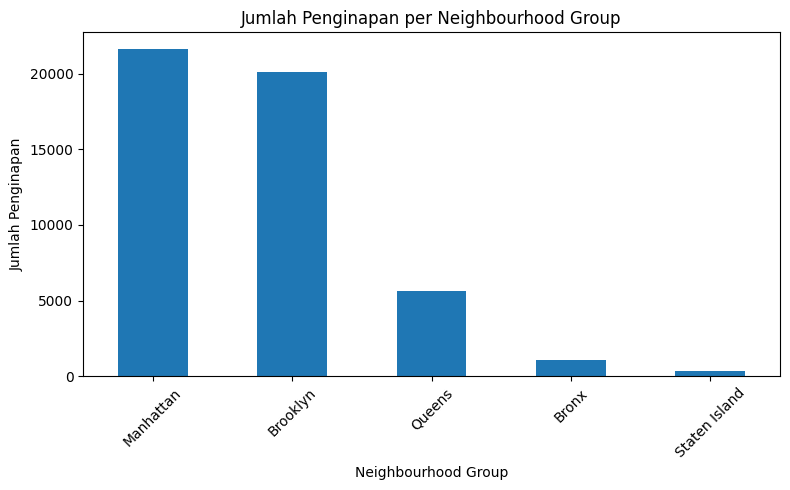

Neighbourhood group dengan penginapan terbanyak:
neighbourhood_group
Manhattan        21643
Brooklyn         20089
Queens            5664
Bronx             1089
Staten Island      373
Name: count, dtype: int64


In [126]:
# Neighbourhood group dengan jumlah penginapan terbanyak
neighbourhood_group_counts = df_airbnb_clean['neighbourhood_group'].value_counts().head(10)

# Visualisasi diagram batang
plt.figure(figsize=(8, 5))
neighbourhood_group_counts.plot(kind='bar')
plt.title('Jumlah Penginapan per Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Jumlah Penginapan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menampilkan data
print("Neighbourhood group dengan penginapan terbanyak:")
print(neighbourhood_group_counts)

### Tambahan

In [127]:
## durasi menginap paling cepat by rata-rata

avg_nights_room_type = df_airbnb_clean.groupby('room_type')['minimum_nights'].mean()
print(avg_nights_room_type)


room_type
Entire home/apt    8.470090
Private room       5.380750
Shared room        6.479724
Name: minimum_nights, dtype: float64


room_type
Entire home/apt    211.806994
Private room        89.794360
Shared room         70.075928
Name: price, dtype: float64


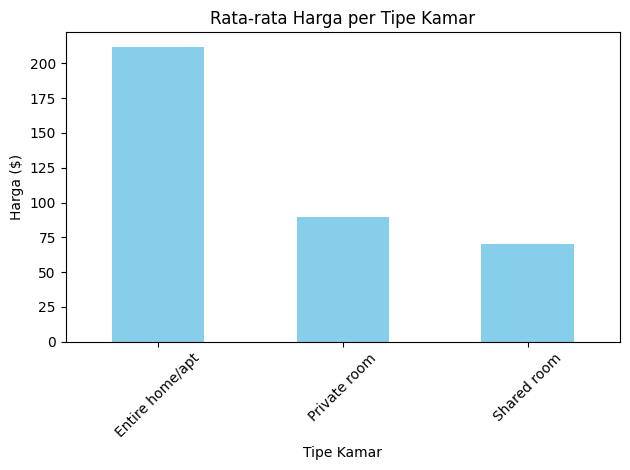

In [128]:
# Hitung rata-rata harga per room type
avg_price_room_type = df_airbnb_clean.groupby('room_type')['price'].mean()
print(avg_price_room_type)

# Visualisasi rata-rata harga per room type
avg_price_room_type.plot(kind='bar', title='Rata-rata Harga per Tipe Kamar', ylabel='Harga ($)', xlabel='Tipe Kamar', color='skyblue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analisis Distribusi Room Type Berdasarkan Neighbourhood Group

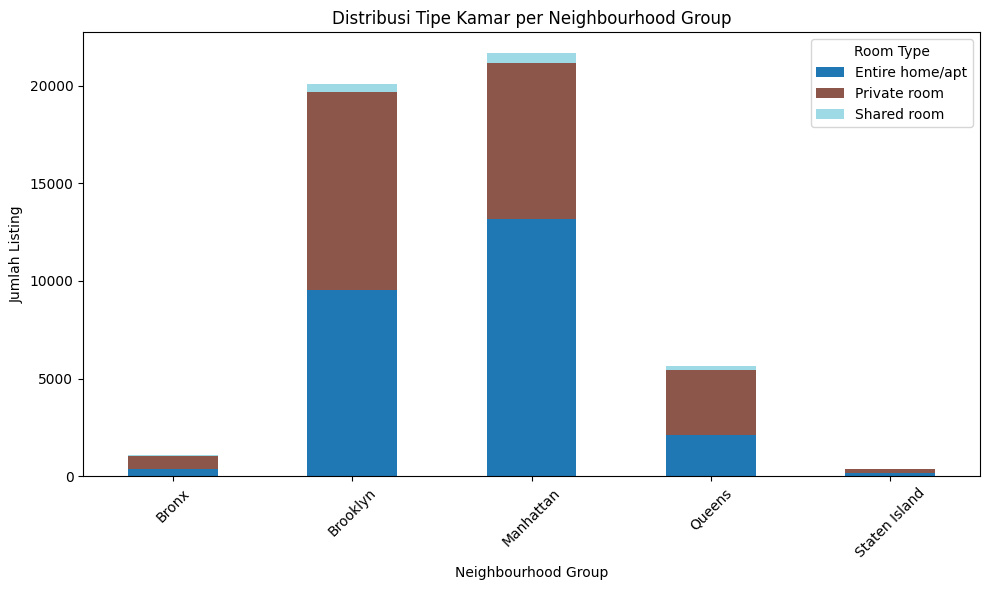

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                            378           652           59
Brooklyn                        9553         10123          413
Manhattan                      13190          7973          480
Queens                          2096          3370          198
Staten Island                    176           188            9


In [129]:
# Hitung jumlah room_type per neighbourhood_group
room_dist = df_airbnb_clean.groupby(['neighbourhood_group', 'room_type']).size().unstack().fillna(0)

# Visualisasi
room_dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Distribusi Tipe Kamar per Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Jumlah Listing')
plt.legend(title='Room Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tampilkan tabel
print(room_dist)


### Perbadingan harga room bedasarkan tipe nya dan neigbourhood nya

In [130]:
# Hitung rata-rata harga berdasarkan kombinasi neighbourhood_group dan room_type
avg_price = df_airbnb_clean.groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()

# Tampilkan tabel
print(avg_price)

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                     127.645503     66.788344    58.610169
Brooklyn                  178.362609     76.510619    50.527845
Manhattan                 249.238211    116.805594    88.977083
Queens                    147.050573     71.776855    69.020202
Staten Island             173.846591     62.292553    57.444444


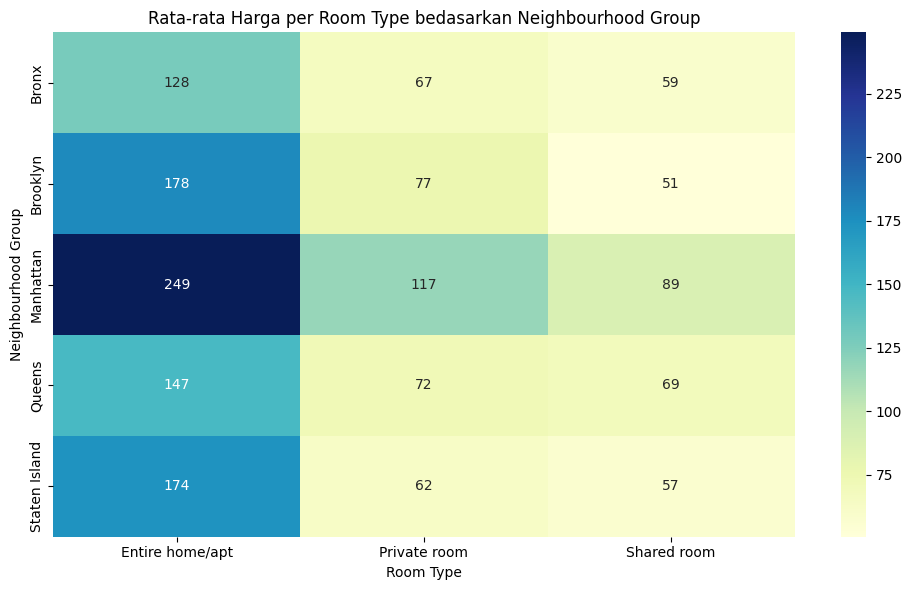

In [131]:
# Visualisasi
plt.figure(figsize=(10, 6))
sns.heatmap(avg_price, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Rata-rata Harga per Room Type bedasarkan Neighbourhood Group')
plt.xlabel('Room Type')
plt.ylabel('Neighbourhood Group')
plt.tight_layout()
plt.show()

In [132]:
## rata-rata lama penginapan bedasarkan room type dan bedasarkan neigbourhood
avg_stay = df_airbnb_clean.groupby(['neighbourhood_group', 'room_type'])['minimum_nights'].mean().unstack()

# Tampilkan tabel
print(avg_stay)


room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                       5.962963      3.858896     3.406780
Brooklyn                    6.531247      5.541638     7.753027
Manhattan                  10.468613      5.451273     6.766667
Queens                      5.369752      5.122552     4.232323
Staten Island               6.238636      3.632979     2.333333


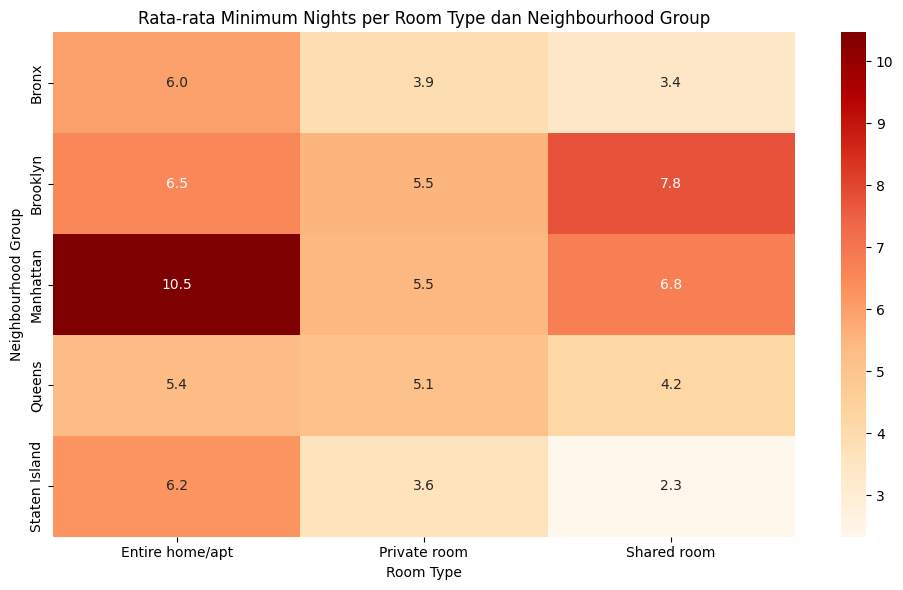

In [133]:
plt.figure(figsize=(10, 6))
sns.heatmap(avg_stay, annot=True, fmt=".1f", cmap="OrRd")
plt.title('Rata-rata Minimum Nights per Room Type dan Neighbourhood Group')
plt.xlabel('Room Type')
plt.ylabel('Neighbourhood Group')
plt.tight_layout()
plt.show()


### Peta Rata-rata Harga per Room Type per Neighbourhood


In [134]:
# Buat data rata-rata harga berdasarkan neighbourhood dan room_type
avg_price_map = df_airbnb_clean.groupby(['neighbourhood', 'room_type']).agg({
    'price': 'mean',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

# Fungsi warna berdasarkan harga
def get_color(price):
    if price < 100:
        return 'green'
    elif price < 200:
        return 'orange'
    else:
        return 'red'

# Inisialisasi peta
map1 = folium.Map(location=[df_airbnb_clean['latitude'].mean(), df_airbnb_clean['longitude'].mean()], zoom_start=11)

# Tambahkan marker
for _, row in avg_price_map.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"{row['neighbourhood']}<br>{row['room_type']}<br>${row['price']:.2f}",
        color=get_color(row['price']),
        fill=True,
        fill_opacity=0.7
    ).add_to(map1)

# Tampilkan peta
map1

### Peta Penyebaran Host Berdasarkan neighbourhood_group

In [139]:
# Ambil hanya host terbanyak per neighbourhood_group
top_hosts = (
    df_airbnb_clean.groupby(['neighbourhood_group', 'host_name'])
    .size()
    .reset_index(name='listing_count')
    .sort_values(['neighbourhood_group', 'listing_count'], ascending=[True, False])
    .groupby('neighbourhood_group')
    .head(1)
)

# Ambil listing mereka
host_properties = df_airbnb_clean.merge(
    top_hosts[['neighbourhood_group', 'host_name']],
    on=['neighbourhood_group', 'host_name']
)

# Siapkan map
map_clustered = folium.Map(
    location=[df_airbnb_clean['latitude'].mean(), df_airbnb_clean['longitude'].mean()],
    zoom_start=11
)

# Warna unik untuk tiap host
host_colors = {}
host_list = top_hosts['host_name'].unique()
color_palette = ['purple', 'darkblue', 'darkgreen', 'cadetblue', 'darkred', 'black', 'gray']
for i, host in enumerate(host_list):
    host_colors[host] = color_palette[i % len(color_palette)]

# Proses per host
for host in host_list:
    data = host_properties[host_properties['host_name'] == host][['latitude', 'longitude', 'room_type', 'price']]
    
    coords = data[['latitude', 'longitude']].values

    # DBSCAN clustering (0.01 approx. 1km if using haversine)
    kms_per_radian = 6371.0088
    epsilon = 0.5 / kms_per_radian  # 500 meters
    db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    labels = db.labels_
    data['cluster'] = labels

    color = host_colors[host]
    
    for cluster_id in np.unique(labels):
        cluster_data = data[data['cluster'] == cluster_id]
        if cluster_id == -1:
            # noise points (outliers)
            continue

        center_lat = cluster_data['latitude'].mean()
        center_lon = cluster_data['longitude'].mean()
        cluster_size = len(cluster_data)
        radius = min(100 + 30 * cluster_size, 1000)  # radius berdasarkan jumlah properti

        folium.Circle(
            location=[center_lat, center_lon],
            radius=radius,
            color=color,
            fill=True,
            fill_opacity=0.25,
            popup=f"{host} | Cluster {cluster_id} | {cluster_size} properties"
        ).add_to(map_clustered)

        # Opsional: titik marker per properti
        for _, row in cluster_data.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=3,
                color=color,
                fill=True,
                fill_opacity=0.9,
                popup=f"{host}<br>{row['room_type']}<br>${row['price']}"
            ).add_to(map_clustered)

map_clustered

### Prediksi Harga Inap

Memprediksi minimum nights (lama inap minimum) berdasarkan:

room_type, 
price, 
neighbourhood_group, 
availability_365, 
number_of_reviews


In [136]:
# 1. Load and prepare data
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


df_model = df_airbnb_clean[['minimum_nights', 'room_type', 'price', 'neighbourhood_group', 'number_of_reviews', 'availability_365']].copy()

# 2. Enhanced data cleaning
# Remove extreme outliers
df_model = df_model[(df_model['minimum_nights'] < 30) & 
                    (df_model['minimum_nights'] > 0) &
                    (df_model['price'] < 500) & 
                    (df_model['price'] > 20)]

# 3. Feature engineering
# Create new features
df_model['price_per_night'] = df_model['price'] / df_model['minimum_nights']
df_model['is_popular'] = np.where(df_model['number_of_reviews'] > df_model['number_of_reviews'].median(), 1, 0)

# 4. Prepare features and target
X = df_model[['room_type', 'price', 'neighbourhood_group', 'availability_365', 'price_per_night', 'is_popular']]
y = df_model['minimum_nights']

# 5. Improved preprocessing
numeric_features = ['price', 'availability_365', 'price_per_night']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_features = ['room_type', 'neighbourhood_group', 'is_popular']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 6. Use better model - Random Forest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        min_samples_leaf=2
    ))
])

# 7. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 8. Train model
model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Improved Mean Squared Error: {mse:.2f}")
print(f"Improved R² Score: {r2:.2f}")

# 10. Feature importance analysis
# Get feature names after one-hot encoding
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

# Get feature importances
importances = model.named_steps['regressor'].feature_importances_
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)

Improved Mean Squared Error: 0.03
Improved R² Score: 1.00

Feature Importances:
                              Feature    Importance
2                     price_per_night  7.541108e-01
0                               price  2.435805e-01
1                    availability_365  2.005892e-03
7        neighbourhood_group_Brooklyn  1.119288e-04
5               room_type_Shared room  3.913081e-05
8       neighbourhood_group_Manhattan  3.667674e-05
11                       is_popular_0  3.328883e-05
12                       is_popular_1  3.002883e-05
9          neighbourhood_group_Queens  2.163695e-05
3           room_type_Entire home/apt  1.970380e-05
4              room_type_Private room  9.395786e-06
10  neighbourhood_group_Staten Island  6.392773e-07
6           neighbourhood_group_Bronx  3.707586e-07


###  Prediksi Harga Properti Airbnb

Mengetahui berapa harga sewa yang sesuai untuk sebuah properti berdasarkan:

['room_type', 'minimum_nights', 'neighbourhood_group', 'neighbourhood', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude']


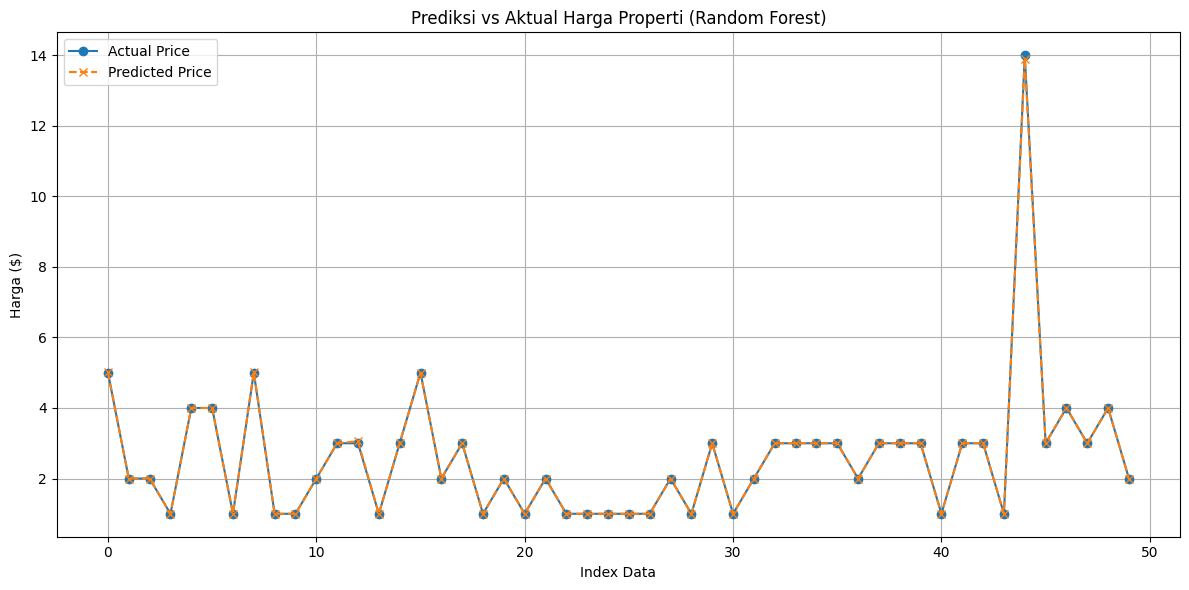

In [137]:
# ------------------- Data Preprocessing -------------------

# Buang outlier harga ekstrem
from sklearn.metrics import mean_absolute_error


df = df_airbnb_clean.copy()
df = df[df['price'] < 500]  # buang properti sangat mahal
df = df[df['price'] > 20]   # buang harga tidak realistis

# Isi missing value agar tidak error saat training
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Fitur baru
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)
df['is_popular'] = (df['number_of_reviews'] > df['number_of_reviews'].median()).astype(int)

# ------------------- Feature Selection -------------------

features = [
    'room_type', 'minimum_nights', 'neighbourhood_group', 'neighbourhood',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365', 'latitude', 'longitude',
    'price_per_review', 'is_popular'
]
target = 'price'

X = df[features]
y = df[target]

# ------------------- Preprocessing Pipeline -------------------

categorical_features = ['room_type', 'neighbourhood_group', 'neighbourhood']
numerical_features = list(set(features) - set(categorical_features))

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# ------------------- Model Pipeline -------------------

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ))
])


# ------------------- Plot -------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual Price', marker='o')
plt.plot(y_pred[:50], label='Predicted Price', marker='x', linestyle='--')
plt.title('Prediksi vs Aktual Harga Properti (Random Forest)')
plt.xlabel('Index Data')
plt.ylabel('Harga ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluasi Model

In [138]:
# ------------------- Train/Test Split & Training -------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# ------------------- Prediction & Evaluation -------------------

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE  : ${mae:.2f}")
print(f"RMSE : ${rmse:.2f}")
print(f"R²   : {r2:.2f}")

MAE  : $6.73
RMSE : $13.88
R²   : 0.97


Interpretasi hasil evaluasi:

MAE (Mean Absolute Error): Rata-rata selisih absolut antara prediksi dan harga asli.

RMSE (Root Mean Squared Error): Sama seperti MAE tapi memberi penalti lebih besar pada kesalahan besar.

R² Score: Skor antara 0 dan 1. Semakin mendekati 1, semakin baik model menjelaskan variasi harga.